In [1340]:
import cudf
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
from cuml.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from cuml.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from cuml.svm import SVC
from cuml import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import cupy as cp
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import GridSearchCV
import sklearn.ensemble 
from xgboost import XGBClassifier
import shap
from sklearn.model_selection import cross_val_score
import cuml
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_val_predict

import warnings

warnings.filterwarnings("ignore")

# Data Preprocessing
missing values, outliers detection, scaling, balancing labels. Use both z score and iqr to classify outliers. Then replace those outliers and missing values with median. Use SMOTE for balancing labels.

In [1341]:
df = pd.read_csv('diabetes.csv')
display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [1342]:
# Convert all the features to float32
for column in df.columns:
    if column != 'Outcome':
        df[column] = df[column].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float32
 1   Glucose                   768 non-null    float32
 2   BloodPressure             768 non-null    float32
 3   SkinThickness             768 non-null    float32
 4   Insulin                   768 non-null    float32
 5   BMI                       768 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    float32
 8   Outcome                   768 non-null    int64  
dtypes: float32(8), int64(1)
memory usage: 30.1 KB


In [1343]:
# Check for null values
null_values = df.isnull().sum()
print(null_values)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [1344]:
# Replace all value that is 0 with NAN
for column in df.columns:
    if column != 'Outcome':
        df[column].replace(0, np.nan, inplace=True)

In [1345]:
def detect_outliers_z_iqr(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Detect outliers using both z-score and iqr
    - df (pd.DataFrame): input df
    - columns (list[str]): columns selected

    Returns:
    - pd.DataFrame: applied outlier detection df
    """
    df_copy = df.copy()
    for column in columns:
        # Z-score method
        z_scores = np.abs(stats.zscore(df_copy[column]))
        z_outliers = z_scores > 3

        # IQR method
        Q1 = df_copy[column].quantile(0.25)
        Q3 = df_copy[column].quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = (df_copy[column] < (Q1 - 1.5 * IQR)) | (df_copy[column] > (Q3 + 1.5 * IQR))

        # Combine both method, true if outlier is in either method
        outliers = z_outliers | iqr_outliers
        
        # Print debug info
        print(f"Column: {column}")
        print(f"Z-score outliers: {df_copy[column][z_outliers].values}")
        print(f"IQR outliers: {df_copy[column][iqr_outliers].values}")
        
        # Replace outlier with nan
        df_copy.loc[outliers, column] = np.nan
        
    return df_copy

In [1346]:
columns = ['Pregnancies','Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction']
df2 = detect_outliers_z_iqr(df, columns)

Column: Pregnancies
Z-score outliers: []
IQR outliers: [15. 17.]
Column: Glucose
Z-score outliers: []
IQR outliers: []
Column: BloodPressure
Z-score outliers: []
IQR outliers: [ 30. 110. 108. 122.  30. 110. 108. 110.  24.  38. 106. 106. 106. 114.]
Column: SkinThickness
Z-score outliers: []
IQR outliers: [60. 63. 99.]
Column: Insulin
Z-score outliers: []
IQR outliers: [543. 846. 495. 485. 495. 478. 744. 370. 680. 402. 375. 545. 465. 415.
 579. 474. 480. 600. 440. 540. 480. 387. 392. 510.]
Column: BMI
Z-score outliers: []
IQR outliers: [53.2 55.  67.1 52.3 52.3 52.9 59.4 57.3]
Column: DiabetesPedigreeFunction
Z-score outliers: [2.288 1.893 1.781 2.329 1.476 2.137 1.731 1.6   2.42  1.699 1.698]
IQR outliers: [2.288 1.441 1.39  1.893 1.781 1.222 1.4   1.321 1.224 2.329 1.318 1.213
 1.353 1.224 1.391 1.476 2.137 1.731 1.268 1.6   2.42  1.251 1.699 1.258
 1.282 1.698 1.461 1.292 1.394]


The article said that zero values in element that has 0 beside the `Outcome` column as the input is the missing value. The reason for that is zero values are not biologically conveivable. Now we need to use both z score and iqr to classify outliers. Then replace the outliers and missing values with the median.

In [1347]:
# Replace NaN, 0, and 0.0 values with the median for each column
for column in columns:
    median_value = df2[column].median() 
    df2[column].replace([np.nan, 0, 0.0], median_value, inplace=True)

In [1348]:
df2

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,120.0,33.599998,0.627,50.0,1
1,1.0,85.0,66.0,29.0,120.0,26.600000,0.351,31.0,0
2,8.0,183.0,64.0,29.0,120.0,23.299999,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.100000,0.167,21.0,0
4,4.0,137.0,40.0,35.0,168.0,43.099998,0.356,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.900002,0.171,63.0,0
764,2.0,122.0,70.0,27.0,120.0,36.799999,0.340,27.0,0
765,5.0,121.0,72.0,23.0,112.0,26.200001,0.245,30.0,0
766,1.0,126.0,60.0,29.0,120.0,30.100000,0.349,47.0,1


In [1349]:
df.shape, df2.shape

((768, 9), (768, 9))

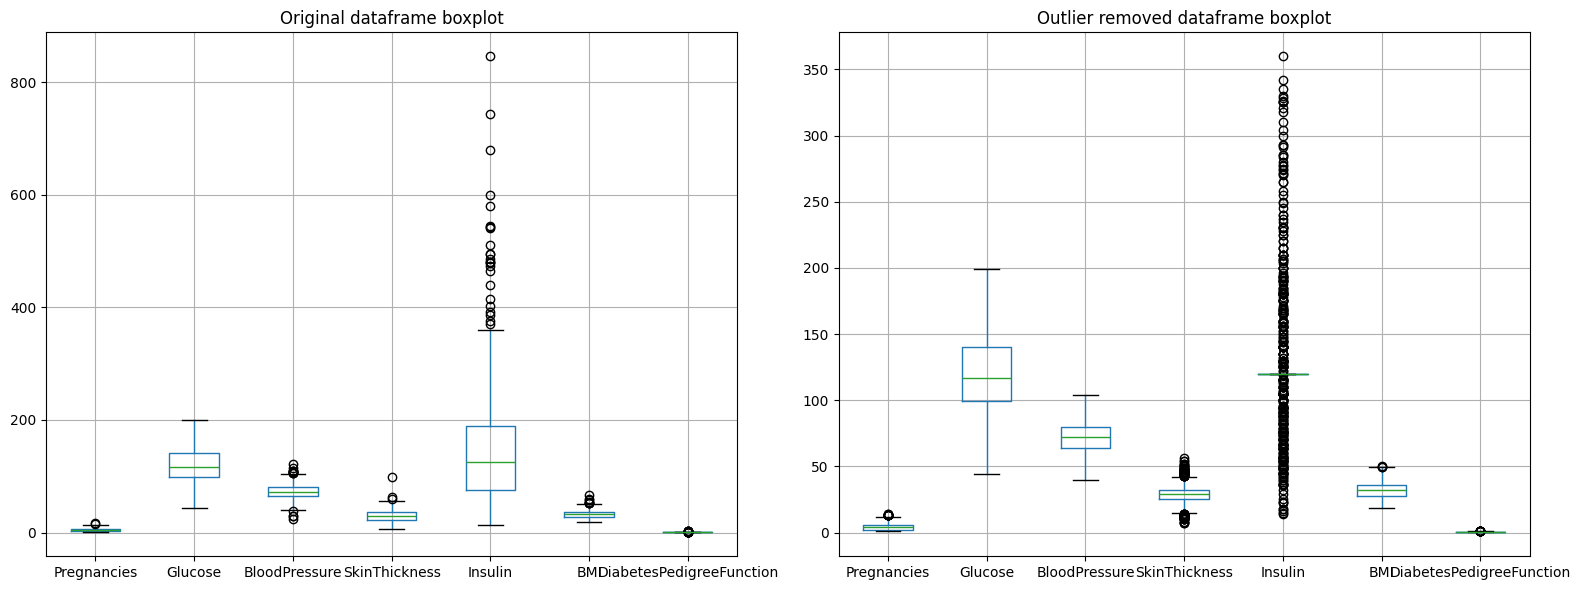

In [1350]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Original dataframe boxplot
df[columns].boxplot(ax=axes[0])
axes[0].set_title('Original dataframe boxplot')

# Outlier removed dataframe boxplot
df2[columns].boxplot(ax=axes[1])
axes[1].set_title('Outlier removed dataframe boxplot')

plt.tight_layout()
plt.show()

In [1352]:
df2.Insulin.describe()

count    768.000000
mean     126.075523
std       51.909477
min       14.000000
25%      120.000000
50%      120.000000
75%      120.000000
max      360.000000
Name: Insulin, dtype: float64

The insulin feature seems to be highly concetrated around the value 120, and there are extreme values that pull the whiskers and make the plot look compressed.

In [1087]:
X = df2.drop('Outcome', axis=1)
y = df2.Outcome

In [1088]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [1089]:
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [1090]:
# Oversample using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

y_resampled.value_counts()

Outcome
1    500
0    500
Name: count, dtype: int64

In [1091]:
# Split data based on the paper
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((700, 8), (300, 8))

I have used or tried to use the same preprocessing step as article.

# 1. Implement the paper ML based models
They use DT, RF, SVM as base models. The base models are trained and each output their own prediction probability. These output then be fed into the meta learner or logistic regression to derive at the final output. The ensemble method is staking.

I suppose they use hyperparameter tuning (include cross validation) to find the best model and combine them into the stacking model. 

Here is the output of their finding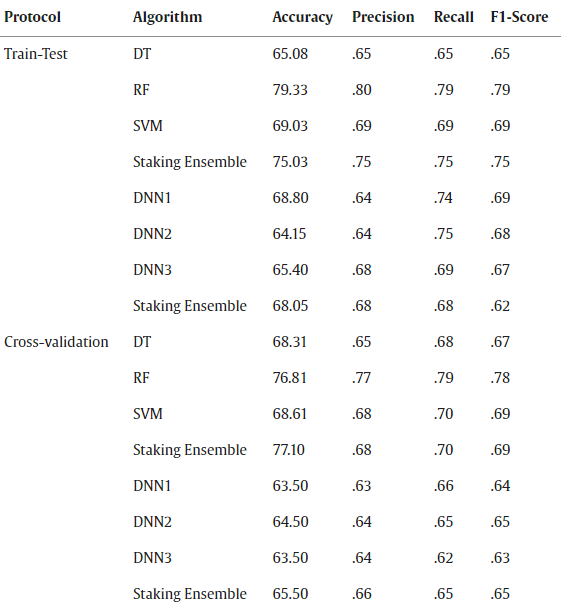

## Random Forest

### Train-test

In [1092]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# y pred
y_pred = rf.predict(X_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

Test Accuracy: 78.33%
Precision: 78.54%
Recall: 78.33%
F1-Score: 78.29%


My stand alone RF performance has similar accuracy to the paper's stand alone RF. Only 1% difference, and I suspect this might be due to the randomness of splitting data.

### Cross-validation

In [ ]:
rf = RandomForestClassifier(random_state=42)

# Ensure the data is in float32 format for cuML compatibility
X_train = X_train.astype(cp.float32)
X_test = X_test.astype(cp.float32)
y_train = y_train.astype(cp.float32)
y_test = y_test.astype(cp.float32)

# Training
param_grid = {
    'n_estimators': np.arange(100, 500, 50),  # Explore values between 100 and 500, stepping by 50
    'split_criterion': [0, 1],  # 0 = gini, 1 = entropy
    'max_depth': np.arange(10, 50, 5),  # Range of tree depths from 5 to 50
    'min_samples_split': np.arange(2, 20, 2),  # Minimum samples to split a node: 2 to 20, stepping by 2
    'min_samples_leaf': np.arange(1, 10, 1)  # Minimum samples at a leaf node: 1 to 9
}
random_search = RandomizedSearchCV(estimator=rf, n_iter=100, param_distributions=param_grid, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best hyperparameter
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'split_criterion': 1, 'n_estimators': 250, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 25}

In [1093]:
# Best hyperparameter model
rf = RandomForestClassifier(
    max_depth = 25,
    min_samples_leaf = 1,
    min_samples_split = 8,
    n_estimators = 250,
    split_criterion = 1,
    random_state = 42
)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")

rf.fit(X_train, y_train)

# y pred
y_pred = rf.predict(X_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

Cross-validation accuracy: 0.8200 (± 0.0131)
Test Accuracy: 78.33%
Precision: 78.69%
Recall: 78.33%
F1-Score: 78.26%


The cross validation and the default RF model is not much different. My cv model is a bit higher than the study, but again, its likely due to the randomness.

## Decision Tree


### Train-set

In [1094]:
clf=DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

Test Accuracy: 71.33%
Precision: 71.50%
Recall: 71.33%
F1-Score: 71.26%


My stand alone DT is 6% higher than the study, which is a decent amout. I will run this with another random state to see if it was really due to randomness

In [1095]:
clf=DecisionTreeClassifier(random_state=42)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

Test Accuracy: 71.33%
Precision: 71.50%
Recall: 71.33%
F1-Score: 71.26%


So it doesn't seem to be a randomness problem. My guess is that there are some different in the preprocessing step. I have read the dataset description and preprocessing (3.1 and 3.2) and implement based on the text, but there are still a decent different in the accuracy. Perhaps, in the outlier removing step, the boundary that consider which data is outlier is different. This might be the most logical explanation I can think of to explain the differences.

### Cross validation

In [ ]:
grid_param={"criterion":["gini","entropy"],
             "splitter":["best","random"],
             "max_depth":np.arange(10, 50, 5),
             "min_samples_leaf":range(1,20,1),
             "min_samples_split":range(2,20,1) 
            }
grid_search=GridSearchCV(estimator=clf,param_grid=grid_param,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)
print(grid_search.best_params_)

In [1096]:
clf=DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_leaf = 19, min_samples_split = 2, splitter= 'best')
clf.fit(X_train,y_train)
y_predicted=clf.predict(X_test)

# Classification report
accuracy = accuracy_score(y_test,y_predicted) * 100
print(f"Accuracy: {accuracy:.2f}%")

report = classification_report(y_test, y_predicted, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

Accuracy: 71.67%
Precision: 71.67%
Recall: 71.67%
F1-Score: 71.66%


Not much different between my cv DT and stand alone DT. Mine DT seems to be higher than the study.

## SVM

### Train set

In [1097]:
svm = SVC()
svm.fit(X_train, y_train)

# Classification report
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test,y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

report = classification_report(y_test, y_pred, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

Accuracy: 79.33%
Precision: 79.66%
Recall: 79.33%
F1-Score: 79.27%


## Cross validation

In [1098]:
# SVC model
svm = SVC()

# Grid search
param_grid = {
    'C': np.logspace(-3, 2, 10),
    'kernel': ['rbf'],
    'gamma': ['scale']
}
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best hyperparameter
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Model accuracy
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy}")

Best parameters: {'C': 2.1544346900318843, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.8


In [1099]:
# Classification report
y_pred = best_model.predict(X_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

report = classification_report(y_test, y_pred, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

Test Accuracy: 80.00%
Precision: 80.25%
Recall: 80.00%
F1-Score: 79.95%


Similar to DT, my SVM (stand alone and cross validated) does a better job at classifiying than the research. 

## Stacking classifier

### Train test

In [1100]:
stacking_clf = StackingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=10,
                                     min_samples_leaf=6, min_samples_split=15, splitter='best')),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, C=2.1544346900318843,
                   gamma='scale', kernel='rbf'))
    ],
    final_estimator=LogisticRegression(random_state=42),
)
stacking_clf.fit(X_train, y_train)

# Classification report
y_pred = stacking_clf.predict(X_test)

accuracy = accuracy_score(y_test,y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

report = classification_report(y_test, y_pred, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

[I] [13:42:49.288596] Unused keyword parameter: random_state during cuML estimator initialization
Accuracy: 78.00%
Precision: 78.39%
Recall: 78.00%
F1-Score: 77.91%


### Cross validation

In [1101]:
stacking_clf = StackingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=10,
                                     min_samples_leaf=6, min_samples_split=15, splitter='best')),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, C=2.1544346900318843,
                   gamma='scale', kernel='rbf'))
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)
stacking_clf.fit(X_train, y_train)

# Classification report
y_pred = stacking_clf.predict(X_test)

accuracy = accuracy_score(y_test,y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

report = classification_report(y_test, y_pred, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

[I] [13:42:56.555909] Unused keyword parameter: random_state during cuML estimator initialization
Accuracy: 78.00%
Precision: 78.39%
Recall: 78.00%
F1-Score: 77.91%


There doesn't seem to be any different between stand along and cross validating in stacking classifier. My stacking classifier does better prediction than the paper. The different is not much, but then again, this might be due to the combination of randomness and differences in the boundary of the outlier removal.

# 2. My solution to the problem

## Data cleaning

In [1353]:
df = pd.read_csv('diabetes.csv')
display(df.head())
display(df.info())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

In [1354]:
for column in df.columns:
    if column != 'Outcome':
        df[column] = df[column].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float32
 1   Glucose                   768 non-null    float32
 2   BloodPressure             768 non-null    float32
 3   SkinThickness             768 non-null    float32
 4   Insulin                   768 non-null    float32
 5   BMI                       768 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    float32
 8   Outcome                   768 non-null    int64  
dtypes: float32(8), int64(1)
memory usage: 30.1 KB


They said that `Pregnancies` of 0 is not possible, but I just think that 0 means they have not been impregnated.

### Outliers removed

In [1355]:
for column in df.columns:
    if column not in ['Outcome', 'Pregnancies']:
        df[column].replace(0, np.nan, inplace=True)

In [1356]:
def detect_outliers_z_iqr(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Detect outliers using both z-score and iqr
    - df (pd.DataFrame): input df
    - columns (list[str]): columns selected

    Returns:
    - pd.DataFrame: applied outlier detection df
    """
    df_copy = df.copy()
    for column in columns:
        # Z-score method
        z_scores = np.abs(stats.zscore(df_copy[column]))
        z_outliers = z_scores > 3

        # IQR method
        Q1 = df_copy[column].quantile(0.25)
        Q3 = df_copy[column].quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = (df_copy[column] < (Q1 - 1.5 * IQR)) | (df_copy[column] > (Q3 + 1.5 * IQR))

        # Combine both method, true if outlier is in either method
        outliers = z_outliers | iqr_outliers
        
#         # Print debug info
#         print(f"Column: {column}")
#         print(f"Z-score outliers: {df_copy[column][z_outliers].values}")
#         print(f"IQR outliers: {df_copy[column][iqr_outliers].values}")
        
        # Replace outlier with nan
        df_copy.loc[outliers, column] = np.nan
        
    return df_copy

In [1357]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [1358]:
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
df2 = detect_outliers_z_iqr(df, columns)

Clip `Insulin` to a reasonable range since I don't like extreme values.

In [1359]:
df2['Insulin'] = df['Insulin'].clip(upper=250.0)

In [1360]:
# Replace NaN, inf, 0, and 0.0 values with the median for each column
for column in columns:
    median_value = df2[column].median() 
    df2[column].replace([np.nan, np.inf, -np.inf], median_value, inplace=True)

#### Feature engineer

In [1361]:
# Creating interaction features
df2['Glucose_Insulin'] = df2['Glucose'] * df2['Insulin']
df2['Glucose_Age'] = df2['Glucose'] * df2['Age']
df2['SkinThickness_BMI'] = df2['SkinThickness'] * df2['BMI']
df2['Glucose_BMI'] = df2['Glucose'] * df2['BMI']
df2['Glucose_BloodPressure'] = df2['Glucose'] * df2['BloodPressure']
df2['SkinThickness_BMI'] = df2['SkinThickness'] * df2['BMI']

# Creating ratio features
df2['Glucose_BMI_Ratio'] = df2['Glucose'] / df2['BMI']
df2['BMI_squared_if_High_Glucose'] = np.where(df2['Glucose'] > 120, df2['BMI'] ** 2, df2['BMI'])

### Oversample

In [1362]:
X = df2.drop('Outcome', axis=1)
y = df2.Outcome

In [1363]:
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [1364]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Glucose_Insulin',
       'Glucose_Age', 'SkinThickness_BMI', 'Glucose_BMI',
       'Glucose_BloodPressure', 'Glucose_BMI_Ratio',
       'BMI_squared_if_High_Glucose'],
      dtype='object')

In [1365]:
X2 = X.drop(['BloodPressure', 'SkinThickness', 'Insulin'], axis=1)

In [1366]:
# Apply oversampling
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X2, y)
X_resampled.shape

(1000, 12)

## Model training

In [1367]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

X_train = X_train.astype(cp.float32)
X_test = X_test.astype(cp.float32)
y_train = y_train.astype(cp.float32)
y_test = y_test.astype(cp.float32)

X_train.shape, X_test.shape

((700, 12), (300, 12))

### Random Forest

In [1369]:
rf = sklearn.ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# y pred
y_pred = rf.predict(X_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

Test Accuracy: 84.00%
Precision: 84.60%
Recall: 84.00%
F1-Score: 83.92%


In [1371]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83       149
         1.0       0.80      0.91      0.85       151

    accuracy                           0.84       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.85      0.84      0.84       300



### Gradient Boost

In [1373]:
xgb = XGBClassifier(tree_method='gpu_hist')
xgb.fit(X_train, y_train)

# Predict on test set
y_pred = xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

Test Accuracy: 0.8433333039283752
Precision: 85.15%
Recall: 84.33%
F1-Score: 84.23%


In [1374]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83       149
         1.0       0.80      0.92      0.86       151

    accuracy                           0.84       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.85      0.84      0.84       300



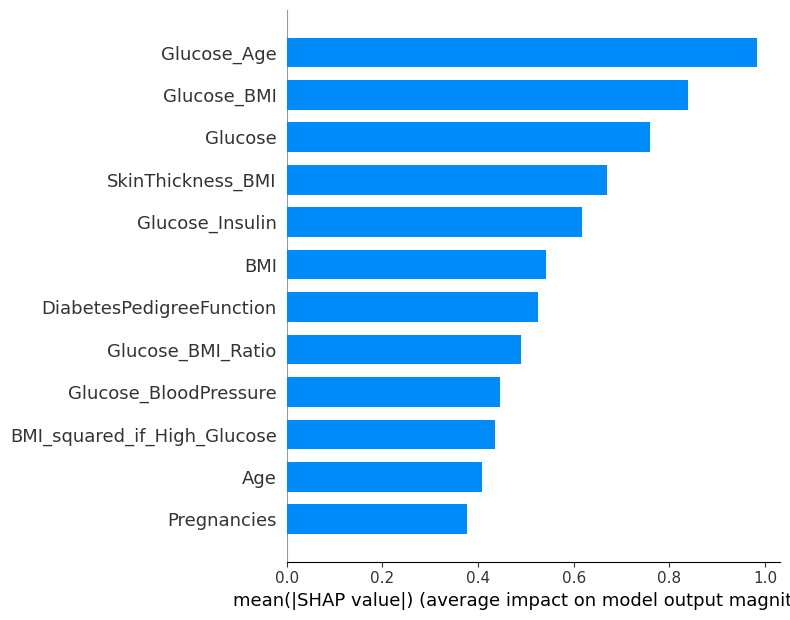

In [1375]:
explainer = shap.explainers.GPUTree(xgb, X_test.to_numpy())
shap_values = explainer(X_test.to_numpy())
shap_values = shap_values
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Stacking model

In [1376]:
# Stacking model
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
    ],
    final_estimator=LogisticRegression(random_state=42),  # Meta-model
    cv=5 
)
stacking_model.fit(X_train, y_train)

# Y pred
y_pred = stacking_model.predict(X_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1_score = report['weighted avg']['f1-score'] * 100

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1_score:.2f}%")

[I] [18:09:34.274108] Unused keyword parameter: random_state during cuML estimator initialization
Test Accuracy: 85.00%
Precision: 85.44%
Recall: 85.00%
F1-Score: 84.95%


In [1377]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84       149
         1.0       0.82      0.91      0.86       151

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300



### Hyperparameter tune model

#### Random Forest

In [1334]:
rf = RandomForestClassifier(random_state=42)

# Training
param_grid = {
    'n_estimators': np.arange(100, 500, 50),  # Explore values between 100 and 500, stepping by 50
    'split_criterion': [0, 1],  # 0 = gini, 1 = entropy
    'max_depth': np.arange(10, 50, 5),  # Range of tree depths from 5 to 50
    'min_samples_split': np.arange(2, 20, 2),  # Minimum samples to split a node: 2 to 20, stepping by 2
    'min_samples_leaf': np.arange(1, 10, 1)  # Minimum samples at a leaf node: 1 to 9
}
random_search = RandomizedSearchCV(estimator=rf, n_iter=100, param_distributions=param_grid, cv=5, random_state=42, n_jobs=2)
random_search.fit(X_train, y_train)

# Best hyperparameter
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'split_criterion': 0, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20}


Best parameters: {'split_criterion': 0, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20}

In [1336]:
best_para = random_search.best_params_
best_rf = RandomForestClassifier(**best_para, random_state=42)
best_rf.fit(X_train, y_train)

# y prediction
y_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 0.8300


### Gradient Boost

In [1337]:
xgb = XGBClassifier(tree_method='gpu_hist')

# Define the expanded parameter grid
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 10, 15],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.05, 0.1],
    'reg_lambda': [0.01, 0.05, 0.1, 0.5],
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_iter=200, 
    n_jobs=2,
    random_state=42
)

# Fit the model with early stopping
random_search.fit(X_train, y_train, verbose=0)

# Output best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

/home/tomadonna/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:51:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/tomadonna/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:51:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/tomadonna/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:51:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device =

Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}
Best Score: 0.8371428571428572


Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}

In [1339]:
best_param = random_search.best_params_
best_xgb = XGBClassifier(**best_param, tree_method='gpu_hist')
best_xgb.fit(X_train, y_train)

# y prediction
y_pred = best_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 0.8233


Seems like hyperparameter tuning causes the tree models to overfit.